In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
data_dir = './plantvillage dataset/color'
num_classes = 38
batch_size = 32
num_epochs = 40
model_path = './model/resnet34_plant_disease.pth' 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\Akshat Nautiyal\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Akshat Nautiyal\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

torch.save(model.state_dict(), model_path)
print("Model saved to", model_path)


Epoch [1/10], Loss: 0.6867
Epoch [2/10], Loss: 0.2981
Epoch [3/10], Loss: 0.2243
Epoch [4/10], Loss: 0.1801
Epoch [5/10], Loss: 0.1482
Epoch [6/10], Loss: 0.1222
Epoch [7/10], Loss: 0.1039
Epoch [8/10], Loss: 0.0938
Epoch [9/10], Loss: 0.0770
Epoch [10/10], Loss: 0.0651
Model saved to ./model/resnet34_plant_disease.pth


In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9424
F1 Score: 0.9429
Precision: 0.9471
Recall: 0.9424


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report:\n", report)

Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.86      0.93      0.90       134
                                 Apple___Black_rot       0.97      0.87      0.92       127
                          Apple___Cedar_apple_rust       1.00      0.94      0.97        51
                                   Apple___healthy       0.93      0.96      0.94       340
                               Blueberry___healthy       0.92      0.99      0.96       306
          Cherry_(including_sour)___Powdery_mildew       1.00      0.95      0.98       210
                 Cherry_(including_sour)___healthy       0.99      0.97      0.98       195
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.90      0.79      0.84       105
                       Corn_(maize)___Common_rust_       0.95      0.97      0.96       239
               Corn_(maize)___Northern_Leaf_Blight     

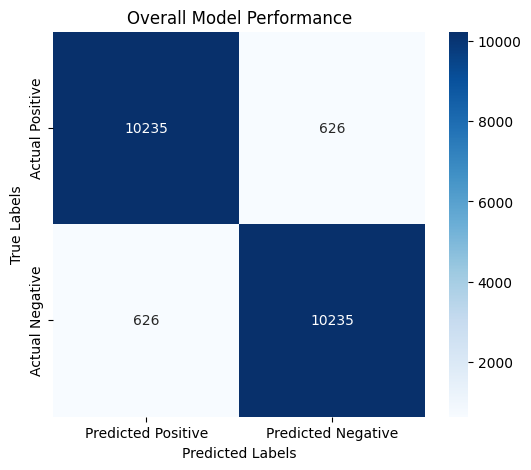

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

correct_predictions = sum(1 for true, pred in zip(all_labels, all_preds) if true == pred)
incorrect_predictions = len(all_labels) - correct_predictions

true_positive = correct_predictions
false_negative = incorrect_predictions
false_positive = incorrect_predictions
true_negative = correct_predictions

simplified_conf_matrix = [
    [true_positive, false_negative], 
    [false_positive, true_negative]
]

plt.figure(figsize=(5, 5))
sns.heatmap(simplified_conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted Positive", "Predicted Negative"], 
            yticklabels=["Actual Positive", "Actual Negative"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of ResNet34")
plt.show()


In [9]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms

In [10]:
num_classes = 38  
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('./model/resnet34_plant_disease.pth'))
model.eval()

class_names = dataset.classes

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def detect_disease(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  
    
    with torch.no_grad():  
        output = model(image)
        _, predicted = torch.max(output, 1)
        plant_disease = class_names[predicted.item()]
    return plant_disease

user_image_path = './fien.JPG'
detected_disease = detect_disease(user_image_path)
print(f"Detected Plant Disease: {detected_disease}")


Detected Plant Disease: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


C:\Users\Akshat Nautiyal\AppData\Local\Temp\ipykernel_16708\2689023194.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/resnet34

In [ ]:
# import json

# class_names = dataset.classes

# with open("class_names.json", "w") as f:
#     json.dump(class_names, f)